## Set up parameters

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [44]:
img_width, img_height = 150,150

train_data_dir = '../interim/sample/train'
validation_data_dir = '../interim/sample/valid'
test_data_dir = '../interim/test'

epochs = 10
batch_size = 32
from utils import *

In [14]:
if K.image_dim_ordering() == 'th':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [15]:
input_shape 

(3, 150, 150)

## Define and train model

In [16]:
# dropout
p = 0.5

In [17]:
model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(p))

'''# new for this version
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(p))
'''

model.add(Dense(3))
model.add(Activation('softmax'))

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 32, 148, 148)  896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
activation_11 (Activation)       (None, 32, 148, 148)  0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 32, 74, 74)    0           activation_11[0][0]              
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 32, 72, 72)    9248        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [49]:
#model.load_weights('../models/2nd-submission-weights.h5')

In [50]:
from keras.regularizers import l1, l1l2
l1(0.001)  # L1 regularization

In [19]:
# new for this version: adam instead of rmsprop
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

In [38]:
# augmentation configuration we will use for training
# new for this version

'''
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
'''

train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


# this is the augmentation configuration we will use for validation and testing:
# only rescaling

validation_datagen = ImageDataGenerator(rescale=1. / 255)


validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 195 images belonging to 3 classes.
Found 100 images belonging to 3 classes.


In [43]:
# code snippet to save weights every time the validation loss decreases
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="../models/6-may-856pm.h5", 
                               verbose=1, 
                               save_best_only=True, 
                               save_weights_only=True)

In [37]:
[f  for f in train_generator.filenames if f.find('') > 0]

['Type_1/._aug_1__13_4041.jpeg',
 'Type_2/aug_2__59_4041.jpeg',
 'Type_2/aug_2__14_4041.jpeg',
 'Type_3/aug_3__276_4041.jpeg']

In [45]:
# make sure samples_per_epoch is divisible by batch_size
history = model.fit_generator(train_generator,samples_per_epoch=195,nb_epoch=epochs,validation_data=validation_generator,nb_val_samples=100)

Epoch 1/10
169/195 [=========================>....] - ETA: 16s - loss: 0.8283 - acc: 0.6036

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


201/195 [==============================] - 156s - loss: 0.8168 - acc: 0.6020 - val_loss: 1.0190 - val_acc: 0.5300
Epoch 2/10
195/195 [==============================] - 52s - loss: 0.9215 - acc: 0.5231 - val_loss: 1.0217 - val_acc: 0.5000
Epoch 3/10
195/195 [==============================] - 65s - loss: 0.8349 - acc: 0.6256 - val_loss: 0.9860 - val_acc: 0.5600
Epoch 4/10
195/195 [==============================] - 64s - loss: 0.8272 - acc: 0.6410 - val_loss: 1.0040 - val_acc: 0.5500
Epoch 5/10
195/195 [==============================] - 56s - loss: 0.7601 - acc: 0.6462 - val_loss: 1.0041 - val_acc: 0.5600
Epoch 6/10
195/195 [==============================] - 57s - loss: 0.7018 - acc: 0.6410 - val_loss: 0.9824 - val_acc: 0.6000
Epoch 7/10
195/195 [==============================] - 64s - loss: 0.6231 - acc: 0.7282 - val_loss: 1.1039 - val_acc: 0.5000
Epoch 8/10
195/195 [==============================] - 54s - loss: 0.5458 - acc: 0.8103 - val_loss: 1.0954 - val_acc: 0.5600
Epoch 9/10
195/195

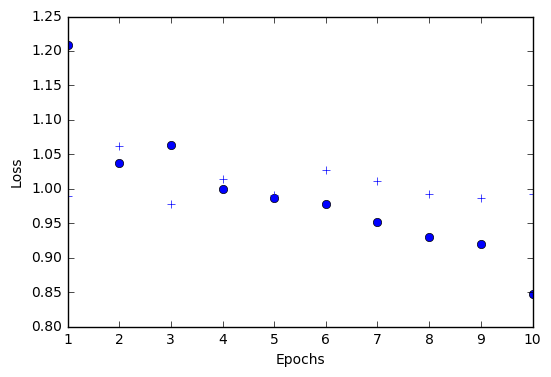

In [23]:
# visualize loss improvements over the run
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

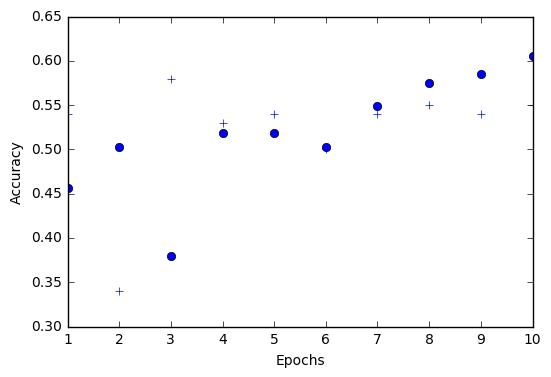

In [24]:
# visualize accuracy improvements over the run
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [10]:
model.evaluate_generator(validation_generator,496)

[0.88178198183736489, 0.55241935483870963]

## Score test set and prepare file for submission

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode=None)

In [ ]:
preds = model.predict_generator(test_generator, val_samples = test_generator.n)

In [ ]:
preds.shape

In [ ]:
preds[:15]

In [ ]:
preds = preds.clip(min=0.05, max=0.95)

In [ ]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = test_generator.filenames
import numpy as np
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [ ]:
filenames[:5]

In [ ]:
ids = ids.reshape(512,1)

In [ ]:
subm = np.concatenate((ids,preds),axis=1)

In [ ]:
subm[:5]

In [ ]:
submission_file_name = '23-april-submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f,%.5f,%.5f', header='image_name,Type_1,Type_2,Type_3', comments='')